In [1]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
        
    def elapsed(self, sec):
        return str(sec) + " secs"
    
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time()-self.start_time))

In [16]:
class DCGAN(object):
    
    def __init__(self, img_rows = 28, img_cols = 28, channel = 1):
        
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None #Discriminator
        self.G = None #Generator
        self.AM = None #Adversarial Model
        self.DM = None #Discriminator Model
        
    def discriminator(self):
        if self.D:
            return self.D
        
        # create a keras sequential model
        self.D = Sequential()
        
        # how many filters in my first layer
        filters = 64
        dropout = 0.4
        
        # add conv layer 1 - 64 filters, filter size is 5x5 , it jumps 2 pixels at a time
        # and it takes in an img which is 28x28x1
        self.D.add(Conv2D(filters=filters*1, kernel_size=5, strides=2, input_shape=(self.img_rows, self.img_cols, self.channel),
                         padding='same', activation=LeakyReLU(alpha=0.2)))
        # randomy switch off certain neurons to prevent overfitting
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(filters=filters*2, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(filters=filters*4, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(filters=filters*8, kernel_size=5, strides=1, padding='same', activation=LeakyReLU(0.2)))
        self.D.add(Dropout(dropout))
        # i will have 512 images which are 4x4 pixels
        
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        # it will output a value between 0 and 1 to denote how real the image is
        self.D.summary()
        return self.D
    
    def generator(self):
        if self.G:
            return self.G
        
        self.G = Sequential()
        dropout = 0.4
        depth = 64*4
        dim = 7
        
        # expect 100 values as input
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        # reshape them into a matrix
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        #outputs twice of previous input
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        # now its 28X28
        
        self.G.add(Conv2DTranspose(1,5,padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G
    
    # it is converting the architecture of the discriminator into a model
    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM
    
    def adversarial_model(self):
        if self.AM:
            return self.AM
        
        optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
        self.AM = Sequential()
        # it is adding the two models back to back
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        
        
        

In [17]:
class MNIST_DCGAN(object):
    
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1
        
        self.x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
        
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
        
        self.DCGAN = DCGAN()
        self.discriminator = self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        
        self.generator = self.DCGAN.generator()
        
    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0,1.0,size=[16,100])
            
        for i in range(train_steps):
            
            # it selects 256 random real images from the mnist dataset
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            
            # generator 256 random noise values
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            # generates 256 random images
            images_fake = self.generator.predict(noise)
            
            # add your real and fake images together
            x = np.concatenate((images_train, images_fake))
           
            # mark the first 256 as 1 and the next 256 as 0
            y = np.ones([2*batch_size, 1])
            y[batch_size:,:] = 0
            
            
            # train the discriminator on these 512 real + fake images
            d_loss = self.discriminator.train_on_batch(x,y)
            
            
            # generate 256 new fake images, mark them as 1 and pass them through the network
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size,100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            
            if save_interval>0:
                
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
        
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename= 'mnist.png'
        
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i,:,:,:]
            
        plt.figure(figsize=(10,10))
        
        for i in range(images.shape[0]):
            plt.subplot(4,4,i+1)
            image = images[i,:,:,:]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis("off")
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
        
        

In [4]:
noise = np.random.uniform(-1.0, 1.0, size=[16,100])

In [5]:
noise[0]

array([ 0.19351976,  0.43048803,  0.21538106, -0.70670492, -0.24176968,
       -0.17041408,  0.21306492,  0.52012824,  0.82190431, -0.05543309,
        0.77944312,  0.2339292 , -0.75928631,  0.14310142,  0.79867526,
        0.5729525 , -0.67927623,  0.46017953,  0.2754592 , -0.62788468,
       -0.9967468 , -0.76762488, -0.04542076,  0.03441053, -0.57196576,
       -0.84906942,  0.97426391, -0.76840276, -0.90872641, -0.9062041 ,
        0.33918072, -0.9567843 , -0.05653281, -0.68545544, -0.06655165,
       -0.49247392,  0.95511936,  0.62721712, -0.44092347, -0.2851462 ,
       -0.82510984,  0.02276676,  0.82041729, -0.49635846, -0.18785479,
        0.79828958,  0.41772887, -0.55441147,  0.90434734,  0.74691212,
       -0.48451421, -0.67880935,  0.70755651, -0.83981038,  0.74736398,
        0.74071078,  0.8696384 ,  0.38207864,  0.97340059,  0.28763158,
       -0.71119975, -0.78375381,  0.18394716,  0.52223724,  0.58767298,
       -0.90519096,  0.22012091, -0.60015871,  0.70458814, -0.28

In [52]:
reshaped = np.reshape(noise[0], (10,10)).astype('float32')

In [53]:
reshaped

array([[ 0.19351976,  0.43048802,  0.21538106, -0.70670491, -0.24176969,
        -0.17041408,  0.21306492,  0.52012825,  0.8219043 , -0.05543309],
       [ 0.77944314,  0.2339292 , -0.75928628,  0.14310142,  0.79867524,
         0.57295251, -0.67927623,  0.46017954,  0.2754592 , -0.62788469],
       [-0.99674678, -0.76762486, -0.04542075,  0.03441053, -0.57196575,
        -0.84906942,  0.97426391, -0.76840276, -0.90872639, -0.9062041 ],
       [ 0.33918074, -0.95678431, -0.05653281, -0.68545544, -0.06655166,
        -0.49247393,  0.95511937,  0.62721711, -0.44092348, -0.28514621],
       [-0.82510984,  0.02276676,  0.82041728, -0.49635845, -0.18785478,
         0.7982896 ,  0.41772887, -0.55441147,  0.90434736,  0.74691212],
       [-0.48451421, -0.67880934,  0.70755649, -0.83981037,  0.74736398,
         0.74071079,  0.86963838,  0.38207865,  0.97340059,  0.28763157],
       [-0.71119976, -0.78375381,  0.18394716,  0.52223724,  0.58767301,
        -0.90519094,  0.22012091, -0.60015869

In [45]:
for i in range(reshaped.shape[0]):
    for t in range(reshaped.shape[1]):
        if reshaped[i][t] < 0:
            reshaped[i][t] = 0
        else:
            reshaped[i][t] = 1

In [54]:
reshaped

array([[ 0.19351976,  0.43048802,  0.21538106, -0.70670491, -0.24176969,
        -0.17041408,  0.21306492,  0.52012825,  0.8219043 , -0.05543309],
       [ 0.77944314,  0.2339292 , -0.75928628,  0.14310142,  0.79867524,
         0.57295251, -0.67927623,  0.46017954,  0.2754592 , -0.62788469],
       [-0.99674678, -0.76762486, -0.04542075,  0.03441053, -0.57196575,
        -0.84906942,  0.97426391, -0.76840276, -0.90872639, -0.9062041 ],
       [ 0.33918074, -0.95678431, -0.05653281, -0.68545544, -0.06655166,
        -0.49247393,  0.95511937,  0.62721711, -0.44092348, -0.28514621],
       [-0.82510984,  0.02276676,  0.82041728, -0.49635845, -0.18785478,
         0.7982896 ,  0.41772887, -0.55441147,  0.90434736,  0.74691212],
       [-0.48451421, -0.67880934,  0.70755649, -0.83981037,  0.74736398,
         0.74071079,  0.86963838,  0.38207865,  0.97340059,  0.28763157],
       [-0.71119976, -0.78375381,  0.18394716,  0.52223724,  0.58767301,
        -0.90519094,  0.22012091, -0.60015869

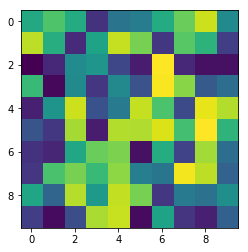

In [55]:
plt.imshow(reshaped)

In [12]:
#np.random.randint(0, 403, 256)

array([242, 164, 128, 124, 389, 324,  91,  83, 388,  63, 157, 144, 232,
        87, 100,  66, 242, 119,  13,  82, 230, 169, 254, 253, 155, 240,
       308, 214, 193, 160, 206, 355, 392, 293, 346, 385, 249, 291, 165,
       211, 308,  32,  25, 132, 120, 186,  92,  11, 372, 193, 157, 211,
       315, 281,  29,  82, 307, 334,  90, 170,  61,  59,  52, 104, 374,
        94, 363, 115,  96, 315, 320, 274,  28, 327,  72, 306,  14, 234,
        80, 179, 171, 270, 368,  19, 351, 232, 130, 272, 281,  58,   1,
        67, 397, 378, 217,  90, 151, 159, 303,  28, 246, 346,  77, 175,
       239,  15,  35, 187, 192, 319, 138, 226,  14, 213, 285,  17, 166,
        72, 218, 361, 227,  74, 341, 106,  37, 297,  27,  69, 287, 241,
        25, 308, 144, 151, 107,  49, 132, 349, 355, 109, 202, 112, 285,
       163,  72,  38, 240, 207, 366, 278, 306, 122, 248, 354,  60,  83,
        32, 235,  98, 312,  16, 284, 124, 367, 271, 206,  26, 389,  70,
       330, 198, 232, 301,  63, 158, 174, 340, 122,  49, 294, 17